/var/folders/lt/152ggfsd6dn70n9w3bmlkrqh0000gn/T/ipykernel_22297/2283018074.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


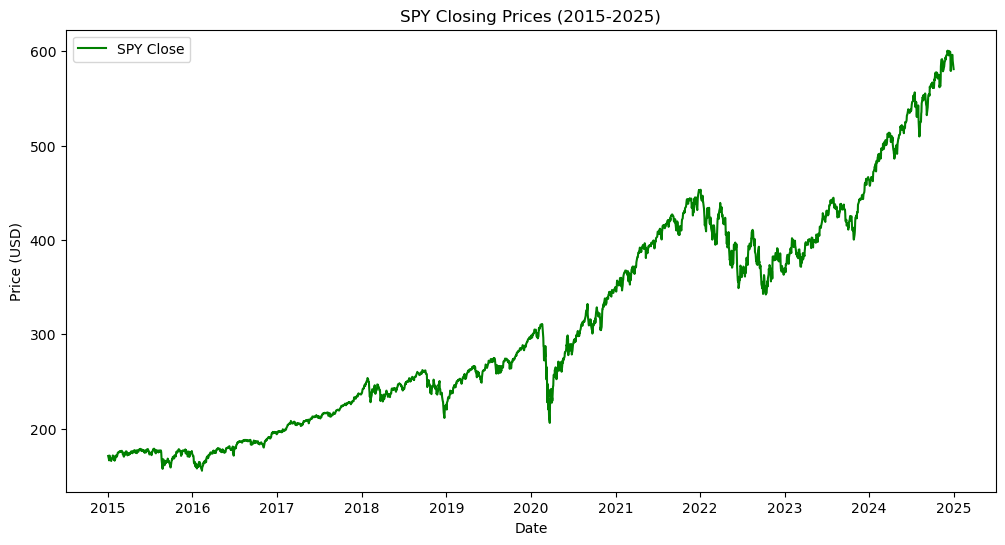

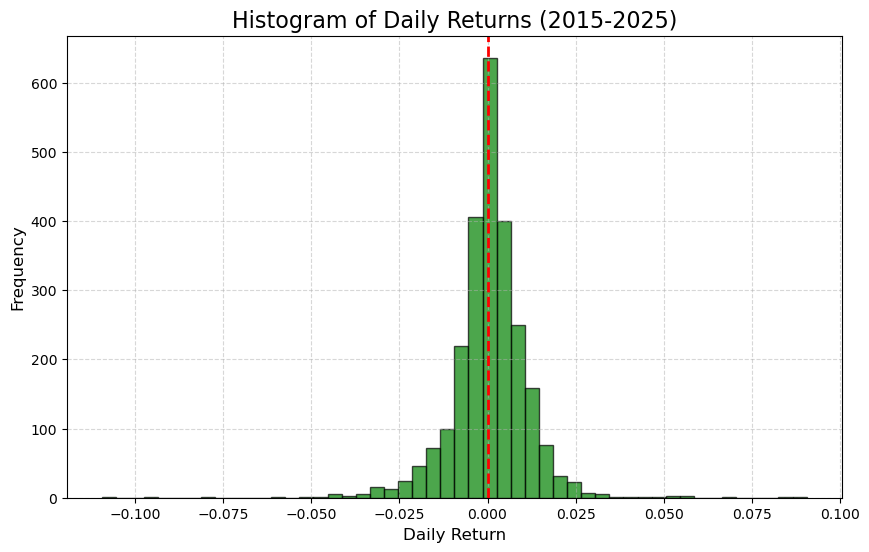

In [25]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns


#downloading SPY ETF since its a proxy for SP500

data = yf.download("SPY", start="2015-01-01", end="2025-01-01")

data.head()

#creating target variable for prediction model

#I want to predict whether the SP500 will close higher or lower tomorrow
# If tomorrows close is greater than todays I will set the target to 1 (price goes up).
# If tomorrows close is less than or equal to todays I set the target to 0 (price goes down or stays the same)

#so pretty much a binary classification problem 
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)

#dropping last row since no tomorrow :(
data = data.dropna()

data.head()

#making a little plot for the closing price
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='SPY Close', color = 'green')
plt.title('SPY Closing Prices (2015-2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

#daily returns histograms

data['Return'] = data['Close'].pct_change()
returns = data['Return'].dropna()

plt.figure(figsize=(10,6))
plt.hist(data['Return'].dropna(), bins=50, color='green', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Return')
plt.title('Histogram of Daily Returns (2015-2025)', fontsize=16)
plt.xlabel('Daily Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [26]:
#Adding Simple Features
print(data.columns)

#this data frame has multi index columsn so gotta flatten it since its easier to use in ML
data.columns = ['_'.join(filter(None, col)).strip() for col in data.columns.values]

print(data.columns)


MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY'),
            ('Target',    ''),
            ('Return',    '')],
           names=['Price', 'Ticker'])
Index(['Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY', 'Target',
       'Return'],
      dtype='object')


In [27]:
#moving averages
data['MA5'] = data['Close_SPY'].rolling(5).mean()
data['MA10'] = data['Close_SPY'].rolling(10).mean()

#rolling volatility (10 day std of returns)
data['Volatility'] = data['Return'].rolling(10).std()

#momentum (price difference over 10 days)
data['Momentum'] = data['Close_SPY'] - data['Close_SPY'].shift(10)

#target variable already exists as 'Target'

# drop rows with NaN in any feature
data = data.dropna(subset=['Return','MA5','MA10','Volatility','Momentum'])

# checking no more NaN values 
print("last 15 rows od dataset:")
print(data.tail(15))



last 15 rows od dataset:
             Close_SPY    High_SPY     Low_SPY    Open_SPY  Volume_SPY  \
Date                                                                     
2024-12-10  595.559448  598.523414  594.897513  598.098586    37234500   
2024-12-11  600.163513  601.121833  598.227034  598.503700    28677700   
2024-12-12  597.071106  599.867070  597.071106  599.294080    31543800   
2024-12-13  596.952515  599.837424  595.569307  599.116212    35904700   
2024-12-16  599.501526  600.479685  597.940547  598.721037    43695200   
2024-12-17  597.031555  597.900990  595.648407  596.932780    55773500   
2024-12-18  579.237915  599.126068  578.852585  596.725263   108248700   
2024-12-19  579.059998  585.877142  578.813000  584.256826    85919500   
2024-12-20  586.015137  590.575156  575.864033  576.716609   125716700   
2024-12-23  589.524353  590.129040  582.555389  585.757373    57635800   
2024-12-24  596.076904  596.116596  590.297529  590.882430    33160100   
2024-12-26  5

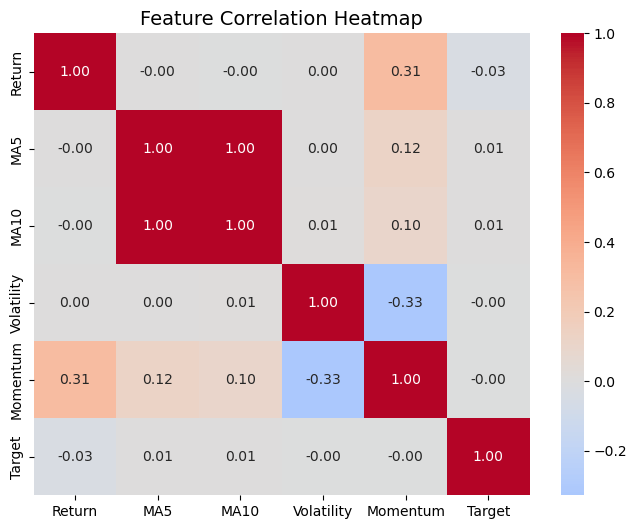

In [28]:
#correlation heatmap 

plt.figure(figsize=(8,6))
sns.heatmap(data[["Return","MA5","MA10","Volatility","Momentum","Target"]].corr(),
            annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

MA5 and MA10 are pretty correlated (=1.00) which is expected because both are moving averages of the same series, but with different windows. Momemtum shows a moderate positive correlation with returns (=0.31) which suggests momentum could be a useful predictor as prices go trending upwards, returns tend to follow. Volatility is slightly negatively correlated with momentum (≈ –0.33). Higher short-term volatility often corresponds to weaker momentum. Target has very weak correlations with all features since its close to 0. 

In [ ]:
#train/test split
from sklearn.model_selection import train_test_split
# Features (X) and Target (y)

#defining features and target
X = data[['Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY', 'Return']]
y = data['Target']

# If there are NaNs, drop them so model training doesn’t fail
X = X.dropna()
y = y.loc[X.index]  #keep alignment


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)



(2004, 6) (502, 6)
(2004,) (502,)
